In [3]:
# Model design
import agentpy as ap
import networkx as nx
import numpy as np
import random 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

In [44]:

categories = ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard'] # tech adoption categories
probabilities = [0.05, 0.1, 0.35, 0.35, 0.15] # fraction of the population that falls into each category
thresholds = [0.0, 0.3, 0.7, 0.8, 0.9] # threshold above which fraction of adopted neighbors will cause agent to adopt

rng = np.random.default_rng()

samples = rng.choice(categories, p=probabilities)
samples

def tech_categorical(categories,probabilities,population_size=100, rng=np.random.default_rng()):
    rng = np.random.default_rng()

    samples = rng.choice(categories, size=population_size,p=probabilities)
    return samples

In [49]:
class InnovationAgent(ap.Agent):
    def setup(self):
        self.adopted = False

        # rng = self.model.random
        rng = np.random
        self.category = rng.choice(self.p.probabilities.keys(), p=self.p.probabilities.values())

    def adopt_innovation(self):
        if not self.adopted:
            if self.category == 'innovator':
                self.adopted = True
            elif self.category in ['early_adopter', 'early_majority', 'late_majority']:
                neighbors = self.network.neighbors(self)
                adopters = sum(1 for n in neighbors if n.adopted)
                threshold = self.model.thresholds[self.category]
                if len(neighbors) > 0 and adopters / len(neighbors) >= threshold:
                    self.adopted = True


In [47]:
class InnovationModel(ap.Model):

    def setup(self):
        graph = nx.watts_strogatz_graph(
            self.p.population,
            self.p.number_of_connections,
            self.p.network_rewire_probability,
        )

        # Create agents and a network
        self.agents = ap.AgentList(self, self.p.population, InnovationAgent)
        self.network = self.agents.network = ap.Network(self, graph)
        self.network.add_agents(self.agents, self.network.nodes)

    def update(self):
        frac_adopted = sum(1 for a in self.agents if a.adopted)/self.p.population
        self.record("fraction adopted" , frac_adopted)

        # Stop if everyone has adopted the tech
        if frac_adopted == 1:
            self.stop()

    def step(self):
        for agent in self.agents:
            agent.adopt_innovation() # Agents adopt innovations based on their category and network connections
    
    def end(self):
        pass
    



In [50]:
parameters = {
    'population': 100,
    "categories": categories,
    "probabilities": dict(zip(categories , probabilities)),
    "thresholds": dict(zip( categories , thresholds )),
    "number_of_connections": 4,
    "network_rewire_probability": 0.1,
}

model = InnovationModel(parameters)
results = model.run()

TypeError: float() argument must be a string or a real number, not 'dict'

In [51]:
p = dict(zip(categories , probabilities))
p

{'innovator': 0.05,
 'early_adopter': 0.1,
 'early_majority': 0.35,
 'late_majority': 0.35,
 'laggard': 0.15}

In [54]:
p.values()

dict_values([0.05, 0.1, 0.35, 0.35, 0.15])

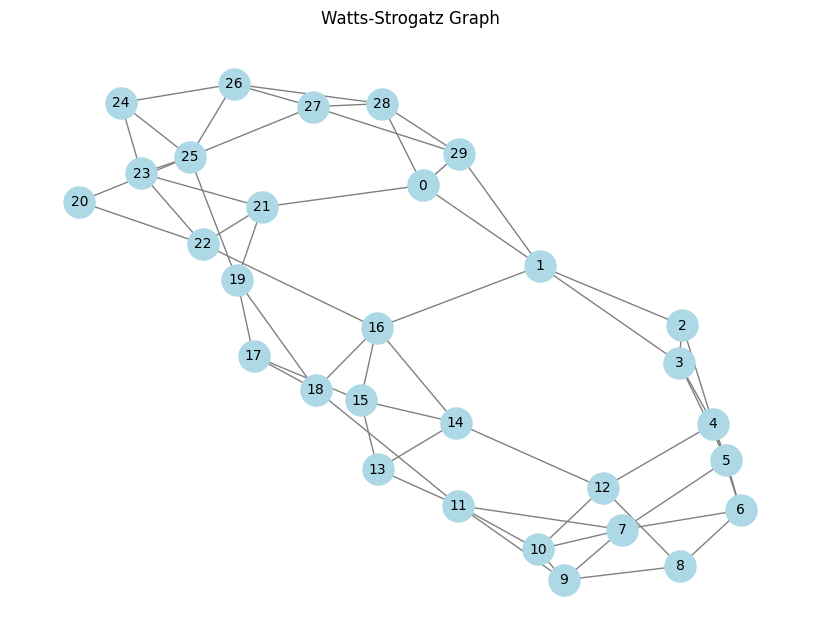

In [39]:
import networkx as nx
import matplotlib.pyplot as plt

# Parameters for the Watts-Strogatz graph
n = 30  # Number of nodes
k = 4   # Each node is connected to k nearest neighbors in ring topology
p = 0.1 # Probability of rewiring each edge

# Create a Watts-Strogatz small-world graph
G = nx.watts_strogatz_graph(n, k, p)

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)

# Show the plot
plt.title("Watts-Strogatz Graph")
plt.show()

In [23]:
p = {categories[i]:probabilities[i] for i in range (len(categories))}
# hash(p)

In [31]:
from collections import namedtuple



frozenset({('early_adopter', 0.1),
           ('early_majority', 0.35),
           ('innovator', 0.05),
           ('laggard', 0.15),
           ('late_majority', 0.35)})

In [33]:
dict(frozenset(p.items()))

{'laggard': 0.15,
 'early_majority': 0.35,
 'innovator': 0.05,
 'late_majority': 0.35,
 'early_adopter': 0.1}

In [20]:
named_p = (zip(categories,probabilities))
hash(named_p)

TypeError: unhashable type: 'dict'

In [14]:




def category_distribution(agent_id, population):
    fractions = {
        'innovator': 0.05,
        'early_adopter': 0.1,
        'early_majority': 0.35,
        'late_majority': 0.35,
        'laggard': 0.15
    }
    thresholds = {
        'innovator': fractions['innovator'] * population,
        'early_adopter': (fractions['innovator'] + fractions['early_adopter']) * population,
        'early_majority': (fractions['innovator'] + fractions['early_adopter'] + fractions['early_majority']) * population,
        'late_majority': (fractions['innovator'] + fractions['early_adopter'] + fractions['early_majority'] + fractions['late_majority']) * population
    }

    if agent_id < thresholds['innovator']:
        return 'innovator'
    elif agent_id < thresholds['early_adopter']:
        return 'early_adopter'
    elif agent_id < thresholds['early_majority']:
        return 'early_majority'
    elif agent_id < thresholds['late_majority']:
        return 'late_majority'
    else:
        return 'laggard'

In [15]:
import agentpy as ap
import networkx as nx
import matplotlib.pyplot as plt

class InnovationAgent(ap.Agent):
    def setup(self):
        self.adopted = False
        self.category = category_distribution(self.id)

    def adopt_innovation(self):
        if not self.adopted:
            if self.category == 'innovator':
                self.adopted = True
            elif self.category in ['early_adopter', 'early_majority', 'late_majority']:
                neighbors = self.model.network.neighbors(self)
                adopters = sum(1 for n in neighbors if n.adopted)
                threshold = self.model.thresholds[self.category]
                if len(neighbors) > 0 and adopters / len(neighbors) >= threshold:
                    self.adopted = True
            elif self.category == 'laggard':
                neighbors = self.model.network.neighbors(self)
                adopters = sum(1 for n in neighbors if n.adopted)
                if len(neighbors) > 0 and adopters / len(neighbors) >= self.model.thresholds['laggard']:
                    self.adopted = True

class DiffusionModel(ap.Model):
    def setup(self):
        graph = nx.watts_strogatz_graph(
            self.p.population,
            self.p.number_of_neighbors,
        
        self.agents = ap.AgentList(self, self.p.population, InnovationAgent)
        
        # self.network = ap.Network(self, self.p.population, self.p.avg_degree)
        # self.network = ap.Network(self,agents=self.agents, connections=self.p.avg_degree)
        self.network.add_edges(self.agents)
        self.agents.setup()

        self.category_distribution = category_distribution
        self.thresholds = {
            'innovator': self.p.innovator_threshold,
            'early_adopter': self.p.early_adopter_threshold,
            'early_majority': self.p.early_majority_threshold,
            'late_majority': self.p.late_majority_threshold,
            'laggard': self.p.laggard_threshold
        }

    def step(self):
        for agent in self.agents:
            agent.adopt_innovation()

    def update(self):
        adopted_agents = sum(1 for a in self.agents if a.adopted)
        self.record('Adopted', adopted_agents)

    def end(self):
        self.record('Final Adoption Rate', sum(1 for a in self.agents if a.adopted) / self.p.population)

def category_distribution(agent_id):
    return (
        'innovator' if agent_id < 5 else
        'early_adopter' if agent_id < 15 else
        'early_majority' if agent_id < 50 else
        'late_majority' if agent_id < 85 else 'laggard'
    )

parameters = ap.Sample({
    'population': 100,
    'avg_degree': 4,
    'steps': 20,
    'category_distribution': category_distribution,
    'innovator_threshold': 0.0,
    'early_adopter_threshold': 0.1,
    'early_majority_threshold': 0.3,
    'late_majority_threshold': 0.5,
    'laggard_threshold': 0.8
})

exp = ap.Experiment(DiffusionModel, parameters, iterations=1)
results = exp.run()

plt.plot(results['t'], results['Adopted'])
plt.title('Diffusion of Innovation Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Number of Adopters')
plt.show()


SyntaxError: '(' was never closed (1102068891.py, line 28)

In [14]:
import networkx as nx

In [13]:
nx.

Type:        module
String form: <module 'agentpy.network' from '/opt/conda/lib/python3.11/site-packages/agentpy/network.py'>
File:        /opt/conda/lib/python3.11/site-packages/agentpy/network.py
Docstring:   Agentpy Network Module 